In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.model_selection import cross_val_score 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import KFold
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from math import sqrt
from sklearn.metrics import mean_squared_error

In [3]:
data=pd.read_csv('nba_2013.csv')
data.head()

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013
3,Arron Afflalo,SG,28,ORL,73,73,2552,464,1011,0.459,...,230,262,248,35,3,146,136,1330,2013-2014,2013
4,Alexis Ajinca,C,25,NOP,56,30,951,136,249,0.546,...,183,277,40,23,46,63,187,328,2013-2014,2013


In [4]:
data.drop(['player','season','season_end'],axis=1,inplace=True)

In [5]:
new_data=data.copy()


In [124]:
new_data.head()

,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,x3p,...,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts
0,SF,23,TOT,63,0,847,66,141,0.468,4,...,0.660,72,144,216,28,23,26,30,122,171
1,C,20,OKC,81,20,1197,93,185,0.503,0,...,0.581,142,190,332,43,40,57,71,203,265
2,PF,27,TOT,53,12,961,143,275,0.520,0,...,0.639,102,204,306,38,24,36,39,108,362
3,SG,28,ORL,73,73,2552,464,1011,0.459,128,...,0.815,32,230,262,248,35,3,146,136,1330
4,C,25,NOP,56,30,951,136,249,0.546,0,...,0.836,94,183,277,40,23,46,63,187,328


(0, 31)

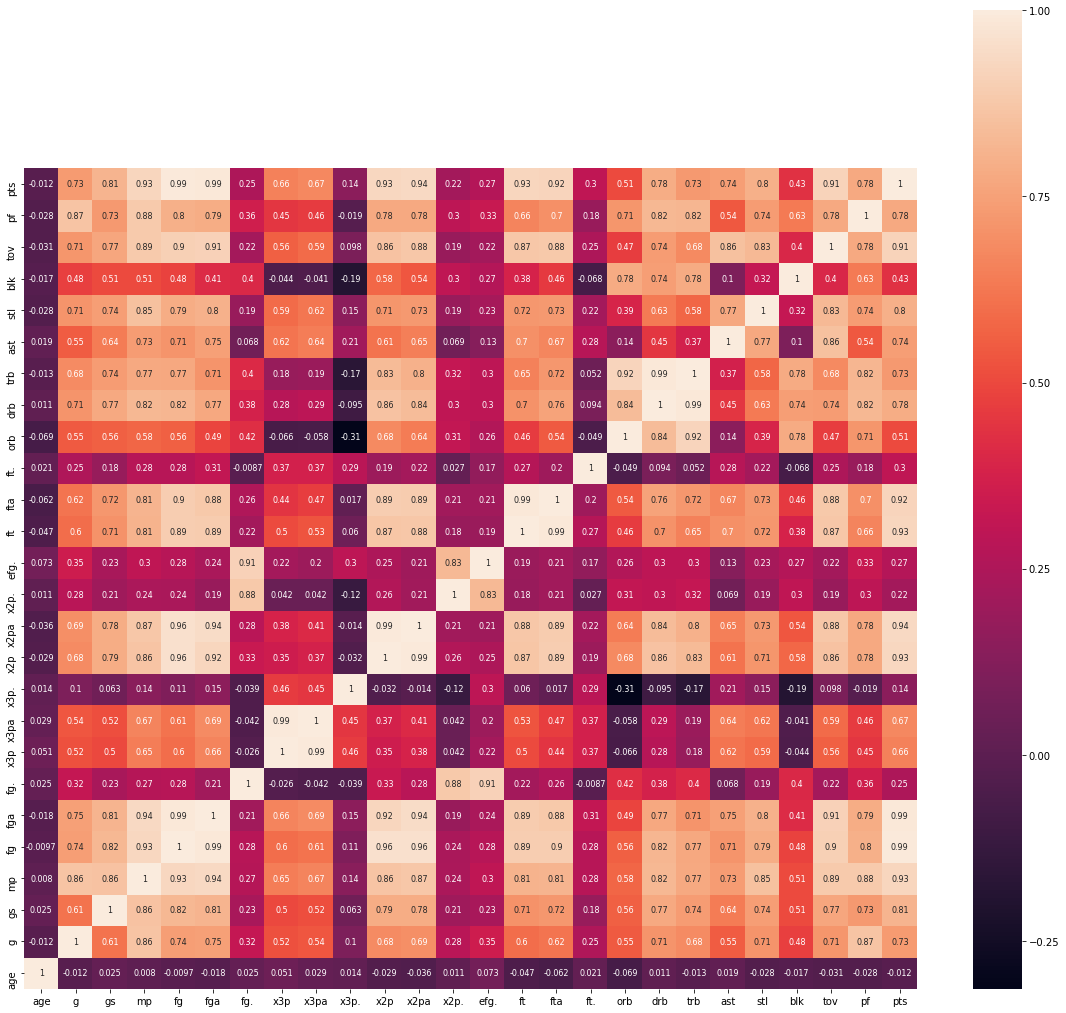

In [17]:
corr = new_data.corr()

fig, ax = plt.subplots(figsize = (20, 18))
sns.heatmap(corr, annot = True, annot_kws={'size': 8})
ax.set_ylim(0 ,31)

In [52]:
new_data.isnull().sum()

pos              0
age              0
bref_team_id     0
g                0
gs               0
mp               0
fg               0
fga              0
fg.              2
x3p              0
x3pa             0
x3p.            67
x2p              0
x2pa             0
x2p.             3
efg.             2
ft               0
fta              0
ft.             20
orb              0
drb              0
trb              0
ast              0
stl              0
blk              0
tov              0
pf               0
pts              0
dtype: int64

### Dropping 'x3p.' Column it has a very low correaltion with target variable

In [6]:
new_data.drop('x3p.',axis=1,inplace=True)

### Filling Null values with mean

In [7]:
new_data.fillna(new_data.mean(),inplace=True)

### Mapping Categorical Data to Numeric Value

In [8]:
position_mapping={'SF': 0, 'C': 1, 'PF': 2,'SG':3,'PG':4,'G':5,'F':6}

new_data['pos'] = new_data['pos'].map(position_mapping)

In [9]:
team_mapping={'TOT':0, 'OKC':1, 'ORL':2, 'NOP':3, 'NYK':4, 'POR':5, 'MIA':6, 'MEM':7, 'BRK':8,
       'PHI':9, 'MIL':10, 'ATL':11, 'WAS':12, 'GSW':13, 'DEN':14, 'HOU':15, 'SAS':16, 'BOS':17,
       'PHO':18, 'MIN':19, 'LAC':20, 'CLE':21, 'UTA':22, 'DET':23, 'CHA':24, 'DAL':25, 'CHI':26,
       'LAL':27, 'IND':28, 'TOR':29, 'SAC':30}
new_data['bref_team_id'] = new_data['bref_team_id'].map(team_mapping)

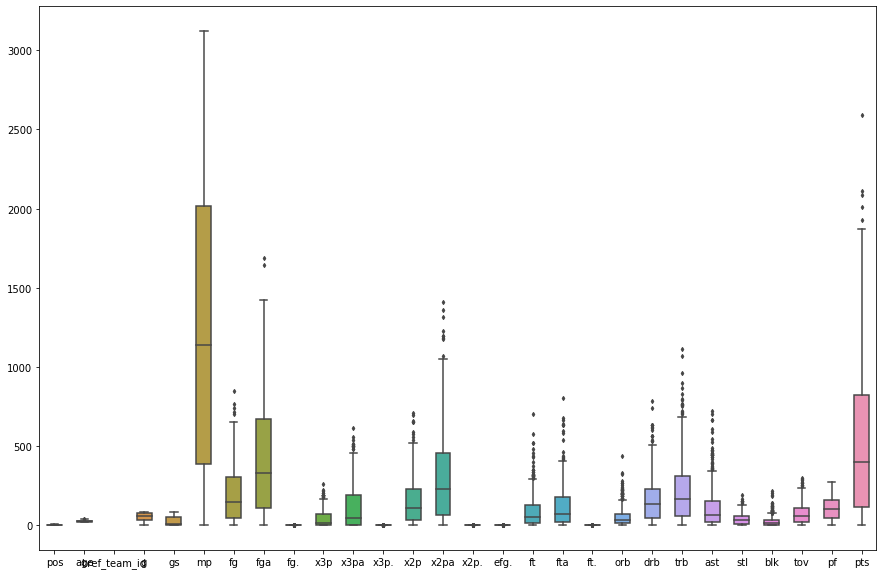

In [31]:

fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=new_data, width= 0.5,ax=ax,  fliersize=3)

### Removing Outliers

In [10]:
Q1 = new_data.quantile(0.25)
Q3 = new_data.quantile(0.75)
IQR= Q3-Q1
IQR

new_data = new_data[~((new_data < (Q1 - 1.5 * IQR)) |(new_data > (Q3 + 1.5 * IQR))).any(axis=1)]
print(new_data.shape)


(330, 27)


In [11]:
copy_data=new_data.copy()

### Defifing Target and Data

In [12]:
y=copy_data['pts']
X=copy_data.drop('pts',axis=1)


### Scaling Data

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [14]:
X_scaled=scaler.transform(X)

### Train Test Split

In [15]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size = 0.30, random_state= 355)

### Implementing graph for PCA

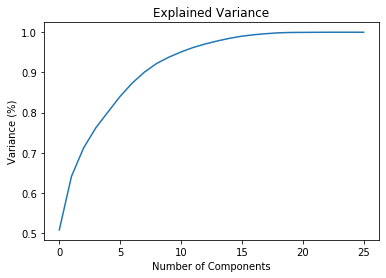

In [17]:
from sklearn.decomposition import PCA
import numpy as np
pca = PCA()
principalComponents = pca.fit_transform(X_scaled)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

### Defining PCA Component 

In [18]:
pca = PCA(n_components=9) # as 95% variance lies in 9 components from above graph
pca_data = pca.fit_transform(X_scaled)

principal_x = pd.DataFrame(pca_data,columns=['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7','PC-8','PC-9'])

In [169]:
principal_x

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9
0,-1.231340,2.483172,-0.459369,-0.599369,-0.720631,-1.548510,-0.326598,0.062410,0.661759
1,1.633284,4.164783,-1.460733,-0.373931,-0.893726,-1.457954,-1.495880,0.886629,0.449285
2,0.619297,3.307262,-0.077173,0.928313,0.316951,-1.021085,-0.087773,0.313679,0.262475
3,7.485909,-2.806294,0.835940,1.902895,-0.057733,-0.686758,1.279078,-1.899463,-0.198066
4,1.080940,3.692936,0.855745,0.436677,-0.654648,-0.768730,0.544189,1.500568,-0.196641
...,...,...,...,...,...,...,...,...,...
325,-0.710322,-0.547363,0.341884,-2.096367,-0.077366,-1.005350,0.583180,-0.438651,0.617560
326,5.674649,-1.401481,-1.733256,2.695853,-0.998342,-0.523244,-1.171982,-1.758590,0.806773
327,4.751127,-2.747191,1.030260,0.581261,-0.899853,1.837235,0.454838,-1.397055,1.773282
328,2.581506,1.615112,-3.262814,0.067085,-1.197517,0.999739,-0.102636,0.563108,1.366768


### Finding RMSE Value for various K value

In [20]:
x_train,x_test,y_train,y_test = train_test_split(principal_x,y,test_size = 0.30, random_state= 50)
rmse_val = [] #to store rmse values for different k
for K in range(20):
    K = K+1
    model = KNeighborsRegressor(n_neighbors = K)

    model.fit(x_train, y_train)  #fit the model
    pred=model.predict(x_test) #make prediction on test set
    error = sqrt(mean_squared_error(y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

RMSE value for k=  1 is: 101.1336249771069
RMSE value for k=  2 is: 85.74875208916154
RMSE value for k=  3 is: 77.70058940390946
RMSE value for k=  4 is: 73.77627506608248
RMSE value for k=  5 is: 73.26780267683009
RMSE value for k=  6 is: 71.31929752721582
RMSE value for k=  7 is: 74.87829471054359
RMSE value for k=  8 is: 75.02179291964961
RMSE value for k=  9 is: 77.03528148090328
RMSE value for k=  10 is: 78.02781620044291
RMSE value for k=  11 is: 76.78197319877795
RMSE value for k=  12 is: 77.35833192331225
RMSE value for k=  13 is: 77.34953542566377
RMSE value for k=  14 is: 79.0195821425754
RMSE value for k=  15 is: 78.35308641267949
RMSE value for k=  16 is: 77.50845328002045
RMSE value for k=  17 is: 77.91002056695231
RMSE value for k=  18 is: 77.77460892213888
RMSE value for k=  19 is: 78.9845901975938
RMSE value for k=  20 is: 79.19220608778684


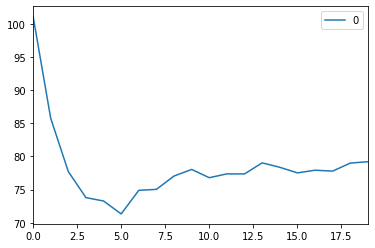

In [171]:
curve = pd.DataFrame(rmse_val) #elbow curve 
curve.plot()

In [21]:
knn=KNeighborsRegressor(n_neighbors = 6)
knn.fit(x_train,y_train)
print("Trainig Score: ",knn.score(x_train,y_train))
print("Testing Score: ",knn.score(x_test,y_test))

Trainig Score:  0.9655530832207377
Testing Score:  0.943151904544993


### With K fold Cross Validation

In [196]:
kfold = KFold(n_splits=10,random_state= 42)
kfold.get_n_splits(principal_x)

10

In [197]:
from statistics import mean
knn = KNeighborsRegressor(n_neighbors = 6)
cnt =0
count=[]
train_score =[]
test_score = []

for train_index,test_index in kfold.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index] # our scaled data is an array so it can work on x[value]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] # y is a dataframe so we have to use "iloc" to retreive data
    knn.fit(X_train,y_train)
    train_score_ = knn.score(X_train,y_train)
    test_score_ =  knn.score(X_test,y_test)
    cnt+=1
    count.append(cnt)
    train_score.append(train_score_)
    test_score.append(test_score_)
    
    print("for k = ", cnt)
    print("train_score is :  ", train_score_, "and test score is :  ", test_score_)
print("************************************************")
print("************************************************")
print("Average train score is :  ", mean(train_score))
print("Average test score is :  ", mean(test_score))

for k =  1
train_score is :   0.9707820515539011 and test score is :   0.9331051718557686
for k =  2
train_score is :   0.9673084563098829 and test score is :   0.9615335037245903
for k =  3
train_score is :   0.966119617664388 and test score is :   0.9751358493644998
for k =  4
train_score is :   0.9706724213226797 and test score is :   0.9596199230865355
for k =  5
train_score is :   0.9676940725217436 and test score is :   0.9670912225069194
for k =  6
train_score is :   0.9709409772790442 and test score is :   0.9545644425690453
for k =  7
train_score is :   0.9686235637935676 and test score is :   0.9578401244225767
for k =  8
train_score is :   0.971083878344376 and test score is :   0.9381377838722135
for k =  9
train_score is :   0.9714485774439189 and test score is :   0.9413021333301033
for k =  10
train_score is :   0.9669834525060849 and test score is :   0.9573595496262522
************************************************
************************************************
Ave

### Hyper Parameter tuning with GridSearchCV

In [192]:
grid_param = {
    'n_neighbors': range(3,20),
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : range(1,20,2),
    
}

from sklearn.model_selection import GridSearchCV
knn = KNeighborsRegressor()
grid_search = GridSearchCV(estimator=knn,
                     param_grid=grid_param,
                     cv=5,
                    n_jobs =-1)
grid_search.get_params()

{'cv': 5,
 'error_score': 'raise-deprecating',
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 5,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'),
 'iid': 'warn',
 'n_jobs': -1,
 'param_grid': {'n_neighbors': range(3, 20),
  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
  'leaf_size': range(1, 20, 2)},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [198]:
x_train,x_test,y_train,y_test = train_test_split(principal_x,y,test_size = 0.30, random_state= 50)
grid_search.fit(x_train,y_train)
best_parameters = grid_search.best_params_
print(best_parameters)

{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 8}


In [199]:

knn = KNeighborsRegressor(algorithm='auto',leaf_size= 1,n_neighbors= 5)
knn.fit(x_train,y_train)
print(knn.score(x_train,y_train))
print(knn.score(x_test,y_test))

0.9648070392217755
0.9400031927479173


In [204]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size = 0.25, random_state= 110)
knn = KNeighborsRegressor(algorithm='auto',leaf_size= 1,n_neighbors= 5)
knn.fit(X_train,y_train)
print(knn.score(X_train,y_train))
print(knn.score(X_test,y_test))

0.9698614221365006
0.9634305308292302


In [212]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
variables = X_scaled

# we create a new data frame which will include all the VIFs
# note that each variable has its own variance inflation factor as this measure is variable specific (not model specific)
# we do not include categorical values for mulitcollinearity as they do not provide much information as numerical ones do
vif = pd.DataFrame()

# here we make use of the variance_inflation_factor, which will basically output the respective VIFs 
vif["VIF"] = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
# Finally, I like to include names so it is easier to explore the result
vif["Features"] = X.columns
vif

,VIF,Features
0,1.681512,pos
1,1.187340,age
2,1.065289,bref_team_id
3,6.709786,g
4,3.956091,gs
5,39.087035,mp
6,inf,fg
7,inf,fga
8,9.497051,fg.
9,inf,x3p


There is many features with value greater than 5 . So there is Multicolinearity

#### Drop features with Multicolinearity

In [215]:
fet=['mp','fta','orb','drb','trb','ft','x3p','x3pa','x2p','x2pa','tov','pf','g','fg.','efg.','ast','fg']

c=copy_data.drop(fet,axis=1)

In [311]:
X=c.drop('pts',axis=1)
y=c['pts']

In [312]:
scaler = StandardScaler()
scaler.fit(X)
X_scaled=scaler.transform(X)

In [239]:
X_train,X_test,y_train,y_test = train_test_split(X_scaled,y,test_size = 0.25, random_state= 110)
grid_param = {
    'n_neighbors': range(3,20),
    'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'leaf_size' : range(1,20,2),
    
}


knn = KNeighborsRegressor()
grid_search = GridSearchCV(estimator=knn,
                     param_grid=grid_param,
                     cv=5,
                    n_jobs =-1)
grid_search.get_params()

{'cv': 5,
 'error_score': 'raise-deprecating',
 'estimator__algorithm': 'auto',
 'estimator__leaf_size': 30,
 'estimator__metric': 'minkowski',
 'estimator__metric_params': None,
 'estimator__n_jobs': None,
 'estimator__n_neighbors': 5,
 'estimator__p': 2,
 'estimator__weights': 'uniform',
 'estimator': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform'),
 'iid': 'warn',
 'n_jobs': -1,
 'param_grid': {'n_neighbors': range(3, 20),
  'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
  'leaf_size': range(1, 20, 2)},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

In [240]:

grid_search.fit(X_train,y_train)
best_parameters = grid_search.best_params_
print(best_parameters)

{'algorithm': 'auto', 'leaf_size': 1, 'n_neighbors': 4}


In [244]:
knn = KNeighborsRegressor(algorithm='auto',leaf_size= 1,n_neighbors= 6)
knn.fit(X_train,y_train)
print("Train Accuracy: ",knn.score(X_train,y_train))
print("Test Accuracy: ",knn.score(X_test,y_test))

Train Accuracy:  0.898742931114852
Test Accuracy:  0.8586295375359841


In [263]:
kfold = KFold(n_splits=10,random_state= 42)
kfold.get_n_splits(X_scaled)

10

In [267]:
from statistics import mean
knn = KNeighborsRegressor(n_neighbors = 6,algorithm='auto',leaf_size= 2)
cnt =0
count=[]
train_score =[]
test_score = []

for train_index,test_index in kfold.split(X_scaled):
    X_train, X_test = X_scaled[train_index], X_scaled[test_index] # our scaled data is an array so it can work on x[value]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index] # y is a dataframe so we have to use "iloc" to retreive data
    knn.fit(X_train,y_train)
    train_score_ = knn.score(X_train,y_train)
    test_score_ =  knn.score(X_test,y_test)
    cnt+=1
    count.append(cnt)
    train_score.append(train_score_)
    test_score.append(test_score_)
    
    print("for k = ", cnt)
    print("train_score is :  ", train_score_, "and test score is :  ", test_score_)
print("************************************************")
print("************************************************")
print("Average train score is :  ", mean(train_score))
print("Average test score is :  ", mean(test_score))

for k =  1
train_score is :   0.9169363924134479 and test score is :   0.8181020621656809
for k =  2
train_score is :   0.9082060746038311 and test score is :   0.8816333907457897
for k =  3
train_score is :   0.90726824816267 and test score is :   0.8786200430415391
for k =  4
train_score is :   0.909600188249171 and test score is :   0.8800161327567426
for k =  5
train_score is :   0.9097975175302919 and test score is :   0.8806612182190285
for k =  6
train_score is :   0.9148396174285585 and test score is :   0.9114665993157782
for k =  7
train_score is :   0.9129309182684988 and test score is :   0.8793566778580844
for k =  8
train_score is :   0.9131917569559588 and test score is :   0.8348733498238171
for k =  9
train_score is :   0.914926677396144 and test score is :   0.7949522238985618
for k =  10
train_score is :   0.9125467361361868 and test score is :   0.8433143881778956
************************************************
************************************************
Avera

In [268]:
corrmat=new_data.corr()

### Function of finding Corelated Feature

In [315]:
def getCorrelatedFeature(corrdata, threshold):
    feature = []
    value = []
    
    for i, index in enumerate(corrdata.index):
        if abs(corrdata[index])> threshold:
            feature.append(index)
            value.append(corrdata[index])
            
    df = pd.DataFrame(data = value, index = feature, columns=['Corr Value'])
    return df

### Function for Runnig a model (With Cross Validation) based on Corelated Feature

In [316]:
def get_accuracy(custom_data):
    from sklearn.preprocessing import StandardScaler
    from statistics import mean
    
    scaler = StandardScaler()
    scaler.fit(custom_data)
    X_scaled=scaler.transform(custom_data)
    
   
    kfold = KFold(n_splits=10,random_state= 42)
    kfold.get_n_splits(X_scaled)
    
  
    knn = KNeighborsRegressor(n_neighbors = 6,algorithm='auto',leaf_size= 2)
    cnt =0
    count=[]
    train_score =[]
    test_score = []

    for train_index,test_index in kfold.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index] # our scaled data is an array so it can work on x[value]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index] # y is a dataframe so we have to use "iloc" to retreive data
        knn.fit(X_train,y_train)
        train_score_ = knn.score(X_train,y_train)
        test_score_ =  knn.score(X_test,y_test)
        cnt+=1
        count.append(cnt)
        train_score.append(train_score_)
        test_score.append(test_score_)
    
    

    print("************************************************")
    print("Average train score is :  ", mean(train_score))
    print("Average test score is :  ", mean(test_score))

### Model train with 90% Corelated feature 

In [317]:
threshold = 0.9
corr_value = getCorrelatedFeature(corrmat['pts'], threshold)
corr_value.index.values
correlated_data = df_out[corr_value.index]
get_accuracy(correlated_data)

************************************************
Average train score is :   0.9925175880826771
Average test score is :   0.9882831225471769


### Model train with 40% Corelated feature 

In [331]:
threshold = 0.4
corr_value = getCorrelatedFeature(corrmat['pts'], threshold)
corr_value.index.values
correlated_data = df_out[corr_value.index]
get_accuracy(correlated_data)

************************************************
Average train score is :   0.9817668937368074
Average test score is :   0.9728418072974471


### Model train with 50% Corelated feature 

In [332]:
threshold = 0.5
corr_value = getCorrelatedFeature(corrmat['pts'], threshold)
corr_value.index.values
correlated_data = df_out[corr_value.index]
get_accuracy(correlated_data)

************************************************
Average train score is :   0.9829215822118806
Average test score is :   0.9748621746149129


### Model train with 60% Corelated feature 

In [333]:
threshold = 0.6
corr_value = getCorrelatedFeature(corrmat['pts'], threshold)
correlated_data = df_out[corr_value.index]
get_accuracy(correlated_data)

************************************************
Average train score is :   0.9829215822118806
Average test score is :   0.9748621746149129


### Model train with 70% Corelated feature 

In [334]:
threshold = 0.7
corr_value = getCorrelatedFeature(corrmat['pts'], threshold)
correlated_data = df_out[corr_value.index]
get_accuracy(correlated_data)

************************************************
Average train score is :   0.9863969732472914
Average test score is :   0.978902395153948


### Model train with 80% Corelated feature 

In [336]:
threshold = 0.8
corr_value = getCorrelatedFeature(corrmat['pts'], threshold)
correlated_data = df_out[corr_value.index]
get_accuracy(correlated_data)

************************************************
Average train score is :   0.9897768127172459
Average test score is :   0.9852901599731224


### Model train with 90% Corelated feature 

In [337]:
threshold = 0.9
corr_value = getCorrelatedFeature(corrmat['pts'], threshold)
correlated_data = df_out[corr_value.index]
get_accuracy(correlated_data)

************************************************
Average train score is :   0.9925175880826771
Average test score is :   0.9882831225471769
